<a href="https://colab.research.google.com/github/MarcoBarroca/VI_EAFEXP_Proj3/blob/main/projetos/marco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from tqdm import tqdm, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
WORK_DIR = '/content/drive/MyDrive/DataP03/'
METADATA_TRAIN='/content/drive/MyDrive/DataP03/plasticc_train_metadata.csv.gz'
DATA_TRAIN='/content/drive/MyDrive/DataP03/plasticc_train_lightcurves.csv.gz'
DATA_TEST='/content/drive/MyDrive/DataP03/plasticc_test_metadata.csv.gz'
DATA_EXTRA='/content/drive/MyDrive/DataP03/plasticc_lightcurves_extra.csv.gz'

In [221]:

train_data = pd.read_csv(DATA_TRAIN,
)

metadata_test=pd.read_csv(DATA_TEST)
test_data=pd.read_csv(DATA_EXTRA)
metadata_train=pd.read_csv(METADATA_TRAIN)


In [64]:
metadata_train

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.7188,-14.9403,0,0.000,0.000,0.000,-9.000,0.013,65,...,0.0,0.0,59570.000,18232,26.4,267.6,742.8,3295.1,6047.5,7955.2
7844,130755807,120.1013,-62.6967,0,0.172,2.561,1.115,46.611,0.136,90,...,0.0,0.0,60056.809,14934,0.0,0.0,0.0,0.0,0.0,0.0
7845,130762946,203.1081,-55.6821,0,0.000,0.000,0.000,-9.000,0.430,16,...,0.0,0.0,59570.000,47805,83.8,1124.7,1445.1,1191.2,848.9,382.5
7846,130772921,79.1016,-35.5018,0,0.000,0.000,0.000,-9.000,0.034,65,...,0.0,0.0,59570.000,22240,1.9,14.4,49.4,244.3,534.8,897.2


In [93]:
train_data

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0
1421701,130779836,60560.0459,1,14.894439,18.947685,0
1421702,130779836,60571.0225,5,30.593130,50.695290,0
1421703,130779836,60585.9974,4,-23.471439,44.819859,0


In [39]:
test[0][0]

615.0

In [105]:
time=[]
flux=[]
flux_error=[]
for i in range(len(train_data_array)):
  if train_data_array[i][0]==713 and train_data_array[i][2]==0:
    time.append(test[i][1])
    flux.append(test[i][3])
    flux_error.append(test[i][4])

In [106]:
train_data.iloc[0]

object_id          615.000000
mjd              59750.422900
passband             2.000000
flux              -544.810303
flux_err             3.622952
detected_bool        1.000000
Name: 0, dtype: float64

In [107]:
time=time-np.min(time)

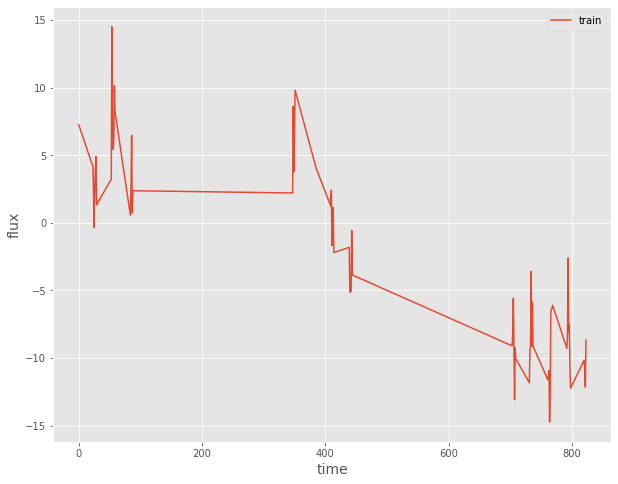

In [108]:
end=600
plt.figure(figsize=(10,8))
#plt.plot(time[:end],flux[:end], label='train')
plt.plot(time,flux, label='train')

plt.xlabel('time', fontsize=14)
plt.ylabel('flux', fontsize=14)
plt.legend()

In [92]:
metadata_train_array=np.array(metadata_train)[:,:-1]
for  i in range(len(metadata_train_array)):
  if metadata_train_array[i][0]==713:
    print(metadata_train_array[i][11])


1.0


In [88]:
metadata_train_array=np.array(metadata_train)[:,:-1]

In [109]:
metadata_train

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.7188,-14.9403,0,0.000,0.000,0.000,-9.000,0.013,65,...,0.0,0.0,59570.000,18232,26.4,267.6,742.8,3295.1,6047.5,7955.2
7844,130755807,120.1013,-62.6967,0,0.172,2.561,1.115,46.611,0.136,90,...,0.0,0.0,60056.809,14934,0.0,0.0,0.0,0.0,0.0,0.0
7845,130762946,203.1081,-55.6821,0,0.000,0.000,0.000,-9.000,0.430,16,...,0.0,0.0,59570.000,47805,83.8,1124.7,1445.1,1191.2,848.9,382.5
7846,130772921,79.1016,-35.5018,0,0.000,0.000,0.000,-9.000,0.034,65,...,0.0,0.0,59570.000,22240,1.9,14.4,49.4,244.3,534.8,897.2


In [247]:
my_dict={42: 0,
        52: 0,
        62: 0,
        67: 0,
        90: 0,
        6: 1,
       64: 1,
       65: 1,
       15: 2,
       95: 2,
       16: 3,
        53: 3,
        92: 3,
        88:4
        }
metadata_train['target_mapped']=metadata_train['target'].map(my_dict)
classes=[0,1,2,3,4]
counts=[]
for i in range(len(classes)):
  train_data[train_data['object_id']==obj_ids[i]]
  count=np.array(metadata_train)==classes[i]
  counts.append(np.sum(count))




In [248]:
metadata_train['target_mapped'].values

array([3, 4, 0, ..., 3, 1, 1])

Text(0, 0.5, 'classes ')

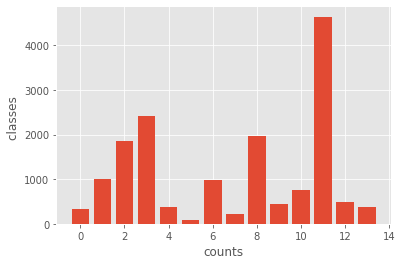

In [122]:
plt.bar(range(len(classes)),counts)
plt.xlabel('counts')
plt.ylabel('classes ')

Text(0, 0.5, 'classes ')

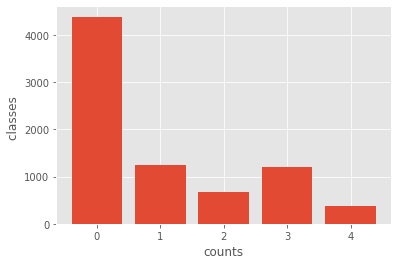

In [284]:
counts=np.unique(y.argmax(1), return_counts=True)[1]
plt.bar(range(len(classes)),counts)
plt.xlabel('counts')
plt.ylabel('classes ')

In [277]:
counts

[71912, 10283, 1525, 1339, 393]

Text(0, 0.5, 'filters ')

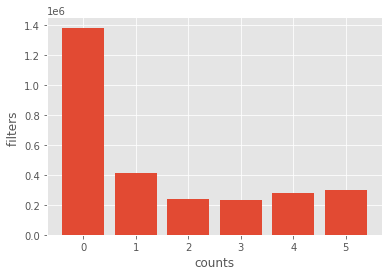

In [129]:
filters=[0,1,2,3,4,5]
counts=[]
for i in range(len(filters)):
  count=np.array(train_data)==filters[i]
  counts.append(np.sum(count))

plt.bar(range(len(filters)),counts)
plt.xlabel('counts')
plt.ylabel('filters ')

In [128]:
counts

[0, 299025]

In [8]:
obj_ids=train_data['object_id'].values
obj_ids_unique=np.unique(obj_ids)

Text(0, 0.5, 'filters ')

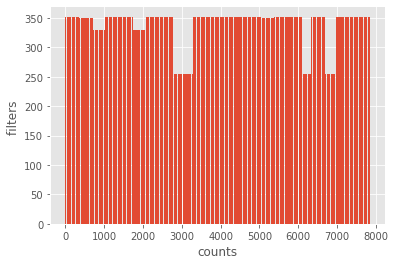

In [137]:
counts=[]
for i in range(len(obj_ids_unique)):
  count=np.array(train_data)==obj_ids_unique[i]
  counts.append(np.sum(count))

plt.bar(range(len(obj_ids_unique)),counts)
plt.xlabel('counts')
plt.ylabel('filters ')

Text(0, 0.5, 'obj_ids ')

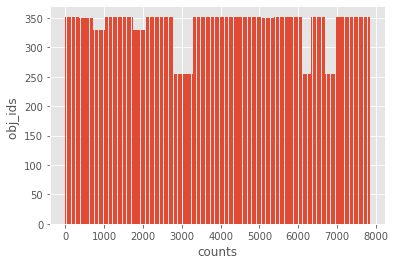

In [140]:
plt.bar(range(len(obj_ids_unique)),counts)
plt.xlabel('counts')
plt.ylabel('obj_ids ')

In [141]:
np.min(counts)

255

In [151]:
amplitudes=[]
for i in range(len(obj_ids_unique)):
  lines=train_data[train_data['object_id']==obj_ids_unique[i]]
  flux=lines['flux'].values
  amplitudes.append(abs(np.max(flux))+abs(np.min(flux)))

Text(0, 0.5, 'amplitudes ')

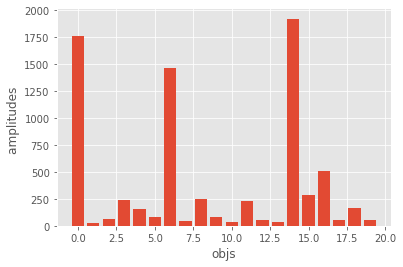

In [166]:
end=20
plt.bar(range(len(obj_ids_unique[:end])),amplitudes[:end])
#plt.bar(range(len(obj_ids_unique)),amplitudes)
plt.xlabel('objs')
plt.ylabel('amplitudes ')

In [84]:
fluxes=[]
for i in range(len(obj_ids_unique)):
  lines=train_data[train_data['object_id']==obj_ids_unique[i]]
  flux=lines['flux'].values
  #fluxes.append([])
  fluxes.append(flux)

In [36]:
import sklearn.preprocessing as pre
fluxes[0] = fluxes[0].reshape(-1, 1)

x_norm = pre.MinMaxScaler(feature_range=(-1,1)).fit_transform(fluxes[0])

In [39]:
np.array(len(fluxes[i]))

array(7848)

In [ ]:
u=[]
g=[]
r=[]
i=[]
z=[]
Y=[]

for j in range(len(filters)):
  u=

for i in range(len(obj_ids_unique)):
  for j in range(len(filters)):

    fluxes[i] = fluxes[i].reshape(-1, 1)
    x_norm = pre.MinMaxScaler(feature_range=(-1,1)).fit_transform(fluxes[i])

In [65]:
rt=tf.ragged.constant(fluxes)
rt = rt.to_tensor()

In [62]:
np.max(rt[0])

0.32104570497163804

In [71]:
test=tf.reduce_min(rt[0])
test

<tf.Tensor: shape=(), dtype=float64, numpy=-1100.440063>

In [86]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(fluxes, maxlen=352, padding='post')
x_norm = pre.MinMaxScaler(feature_range=(-1,1)).fit_transform(x_norm)

In [87]:
x_train

array([[-544, -816, -471, ...,  296,  235,  157],
       [   9,    7,    6, ...,   -8,    0,    0],
       [   1,    2,    2, ...,    0,    0,    0],
       ...,
       [  59,  -14,    7, ...,    0,    0,    0],
       [   8,  -10,   -2, ...,    0,    0,    0],
       [ 571,  749,  811, ...,    0,    0,    0]], dtype=int32)

In [88]:
x_norm = pre.MinMaxScaler(feature_range=(-1,1)).fit_transform(x_norm)

In [91]:
np.min(x_norm[2])

-0.979298306561611

In [93]:
metadata_train['target'].values

array([92, 88, 42, ..., 16, 65,  6])

In [94]:
metadata_train['object_id']

0             615
1             713
2             730
3             745
4            1124
          ...    
7843    130739978
7844    130755807
7845    130762946
7846    130772921
7847    130779836
Name: object_id, Length: 7848, dtype: int64

In [96]:
obj_ids_unique

array([      615,       713,       730, ..., 130762946, 130772921,
       130779836])

In [6]:
obj_ids=metadata_train['object_id'].values
tables=[]
for i in range(len(obj_ids)):
  lines=train_data[train_data['object_id']==obj_ids[i]]
  flux=lines['flux'].values
  error=lines['flux_err'].values
  mjd=lines['mjd'].values
  filter=lines['passband'].values
  fluxes.append(flux)
  errors.append(error)
  mjds.append(mjd)
  filters.append(filter)
  table=np.array([mjd,fluxes,errors,filters])
  tables.append(table)

x = tf.keras.preprocessing.sequence.pad_sequences(fluxes, maxlen=352, padding='post')
y = metadata_train['target'].values
y = pre.LabelBinarizer().fit_transform(y)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, random_state=42)

scaler=pre.MinMaxScaler(feature_range=(-1,1)).fit(x_train)

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_train)

NameError: ignored

In [60]:
import sklearn.preprocessing as pre

obj_ids=metadata_train['object_id']
tables=[]
for i in range(len(obj_ids)):
  lines=train_data[train_data['object_id']==obj_ids[i]]
  flux=np.array(lines['flux'].values)
  error=np.array(lines['flux_err'].values)
  mjd=np.array(lines['mjd'].values)
  filter=np.array(lines['passband'].values)
  table=np.array([mjd,flux,error,filter],dtype=np.float32).T
  table=normalize_table(table)
  tables.append(table)

In [ ]:
obj_ids=metadata_train['object_id']
tables=[]
for i in range(len(obj_ids)):
  lines=train_data[train_data['object_id']==obj_ids[i]]
lines

In [224]:
def normalize_table(tab):
  f_scaler=pre.MinMaxScaler(feature_range=(0,1)).fit(tab[:,1:3])
  #e_scaler=pre.MinMaxScaler(feature_range=(-1,1)).fit(tab[:,2])
  tab[:,1:3]=f_scaler.transform(tab[:,1:3])
  #tab[:,2]=e_scaler.transform(tab[:,2])
  tab[:,0]=tab[:,0]-np.min(tab[:,0])

  return tab

def pre_process(data_df,metadata_df):
  obj_ids=metadata_df['object_id']
  tables=[]
  for i in range(len(obj_ids)):
    if obj_ids[i]!=99:
      lines=data_df[data_df['object_id']==obj_ids[i]]
      flux=np.array(lines['flux'].values)
      error=np.array(lines['flux_err'].values)
      mjd=np.array(lines['mjd'].values)
      filter=np.array(lines['passband'].values)
      table=np.array([mjd,flux,error,filter],dtype=np.float32).T
      table=normalize_table(table)
      tables.append(table)
  if obj_ids[i]!=99:
    y = metadata_train['target'].values
    my_dict={42: 0,
        52: 0,
        62: 0,
        67: 0,
        90: 0,
        6: 1,
       64: 1,
       65: 1,
       15: 2,
       95: 2,
       16: 3,
        53: 3,
        92: 3,
        88:4
        }
    y=[my_dict[i] for i in y]
    y = pre.LabelBinarizer().fit_transform(y)

    

  return tables,y

In [312]:
from tqdm.notebook import tqdm

def normalize_table(tab):
  f_scaler=pre.MinMaxScaler(feature_range=(0,1)).fit(tab[:,1:3])
  #e_scaler=pre.MinMaxScaler(feature_range=(-1,1)).fit(tab[:,2])
  tab[:,1:3]=f_scaler.transform(tab[:,1:3])
  #tab[:,2]=e_scaler.transform(tab[:,2])
  tab[:,0]=tab[:,0]-np.min(tab[:,0])

  return tab

def pre_process(data_df,metadata_df,index):

  if index == 1:
    data_df = data_df.merge(metadata_df[['object_id', 'target']], how= 'inner', on = 'object_id')
  if index == 0:
    data_df = data_df.merge(metadata_df[['object_id', 'true_target']], how= 'inner', on = 'object_id')
  
  
  
  if 'true_target' in data_df.columns:
   data_df = data_df.rename(columns = {'true_target': 'target'}, inplace = False)


  obj_ids_def = data_df[data_df['target'] //99 != 10]
  obj_ids = obj_ids_def['object_id'].unique()
  groups = obj_ids_def.groupby(['object_id'])
  tables=[]
  y=[]
  for i,iid in enumerate(tqdm(obj_ids)):
      #lines = data_df[data_df['object_id'] == obj_ids[i]]
      lines=groups.get_group(iid)
      table = lines[['mjd', 'flux', 'flux_err', 'passband']].values
      table = normalize_table(table)
      tables.append(table)
      y.append(lines['target'].values[0])
  

      
  my_dict={42: 0,
           52: 0,
           62: 0,
           67: 0,
           90: 0,
           6: 1,
           64: 1,
           65: 1,
           15: 2,
           95: 2,
           16: 3,
           53: 3,
           92: 3,
           88:4
        }
  y=[my_dict[i] for i in y]
  y = pre.LabelBinarizer().fit_transform(y)

  return tables, y

In [327]:
x_train,y_train=pre_process(train_data,metadata_train,1)
x_test,y_test=pre_process(test_data,metadata_test,0)

  0%|          | 0/7848 [00:00<?, ?it/s]

[92, 88, 42, 90, 90, 65, 90, 42, 90, 65, 90, 42, 42, 90, 65, 16, 67, 67, 42, 95, 88, 62, 88, 42, 16, 15, 42, 90, 90, 90, 42, 90, 65, 90, 90, 42, 90, 88, 88, 16, 90, 62, 16, 90, 65, 90, 16, 65, 65, 88, 90, 65, 42, 65, 95, 90, 65, 90, 88, 52, 65, 42, 16, 42, 90, 62, 52, 65, 90, 92, 65, 90, 52, 90, 90, 90, 90, 65, 65, 52, 90, 88, 95, 90, 90, 90, 90, 90, 65, 16, 90, 16, 52, 90, 90, 16, 16, 90, 52, 90, 90, 16, 16, 90, 90, 62, 90, 90, 88, 6, 62, 62, 90, 90, 67, 62, 90, 62, 42, 90, 90, 16, 90, 15, 52, 88, 88, 90, 52, 95, 65, 52, 90, 90, 88, 88, 65, 90, 16, 65, 90, 90, 90, 90, 90, 90, 90, 42, 16, 88, 92, 62, 65, 16, 88, 65, 92, 16, 90, 90, 90, 90, 92, 67, 90, 16, 90, 42, 90, 90, 90, 42, 62, 65, 90, 88, 16, 90, 65, 16, 16, 65, 90, 92, 95, 65, 42, 16, 42, 65, 90, 90, 90, 42, 65, 90, 88, 52, 42, 88, 62, 67, 42, 95, 65, 42, 90, 90, 42, 52, 65, 65, 65, 90, 90, 65, 52, 16, 90, 67, 88, 42, 65, 90, 16, 90, 90, 65, 90, 90, 62, 90, 62, 42, 90, 42, 62, 42, 90, 67, 95, 65, 16, 88, 42, 52, 90, 90, 16, 92, 

  0%|          | 0/19920 [00:00<?, ?it/s]

[90, 90, 90, 42, 90, 42, 65, 88, 42, 42, 42, 42, 90, 90, 90, 42, 90, 88, 90, 90, 42, 90, 42, 42, 90, 90, 62, 90, 42, 90, 90, 90, 90, 90, 90, 42, 90, 42, 90, 90, 62, 90, 52, 90, 62, 42, 90, 90, 90, 90, 90, 90, 42, 42, 15, 42, 90, 90, 52, 90, 90, 42, 90, 42, 92, 16, 62, 92, 90, 90, 65, 42, 90, 90, 90, 92, 90, 65, 42, 42, 42, 90, 90, 90, 90, 42, 90, 62, 90, 90, 88, 88, 42, 92, 62, 90, 90, 42, 16, 90, 90, 88, 90, 88, 90, 92, 42, 90, 16, 90, 42, 90, 42, 42, 42, 90, 90, 90, 42, 52, 90, 42, 42, 42, 42, 90, 42, 90, 90, 88, 90, 90, 90, 92, 90, 90, 42, 42, 42, 42, 90, 90, 90, 90, 92, 90, 42, 42, 90, 42, 90, 90, 90, 90, 42, 92, 90, 42, 42, 90, 95, 90, 90, 90, 88, 90, 42, 52, 42, 65, 92, 90, 90, 42, 90, 42, 42, 42, 95, 42, 92, 52, 90, 42, 65, 92, 92, 90, 90, 90, 90, 42, 52, 90, 62, 90, 52, 90, 92, 92, 42, 42, 42, 42, 90, 42, 90, 16, 92, 42, 90, 90, 90, 90, 42, 42, 92, 88, 90, 90, 90, 90, 15, 90, 92, 42, 92, 90, 62, 90, 90, 90, 42, 90, 90, 90, 42, 90, 42, 42, 90, 42, 42, 90, 90, 90, 62, 42, 90, 90,

In [325]:
np.min(x_train[0][:,1])

0.0

In [328]:
pad_x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train,value=-99 ,maxlen=352, padding='post')
pad_x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test,value=-99 ,maxlen=352, padding='post')

#x_train = tf.RaggedTensor.from_row_lengths(values=tf.concat(x_train, axis=0), row_lengths=[a.shape[0] for a in x_train])
#input_lc = tfkl.Input(inputs['lc'].shape[1:], name='lc')

In [329]:
x_train, x_valid, y_train, y_valid = train_test_split(pad_x_train, y_train, test_size=0.10, random_state=42)

#x_train=np.array([xn.astype('float32') for xn in x_train])#x_train.astype('float32')
#y_train=y_train.astype('float32')

In [330]:
x_train.shape

(7063, 352, 4)

In [331]:
np.unique(y.argmax(1), return_counts=True)[1]

array([4381, 1234,  670, 1193,  370])

In [231]:
x_valid.shape

(777, 352, 4)

In [192]:
np.expand_dims(x_train[0], axis=0).shape

(1, 351, 4)

In [ ]:
my_dict={42: 0,
        52: 0,
        62: 0,
        67: 0,
        90: 0,
        6: 1,
       64: 1,
       65: 1,
       15: 2,
       95: 2,
       16: 3,
        53: 3,
        92: 3,
        88:4
        }
metadata_train['target_mapped']=metadata_train['target'].map(my_dict)
classes=[0,1,2,3,4]
counts=[]
for i in range(len(classes)):
  count=np.array(metadata_train)==classes[i]
  counts.append(np.sum(count))


In [285]:
class_weight={0:np.sum(counts)/counts[0],
             1:np.sum(counts)/counts[1],
             2:np.sum(counts)/counts[2],
             3:np.sum(counts)/counts[3],
             4:np.sum(counts)/counts[4]
    }

class_weight

{0: 1.7913718329148596,
 1: 6.359805510534846,
 2: 11.713432835820896,
 3: 6.57837384744342,
 4: 21.21081081081081}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, GlobalMaxPool1D
from tensorflow.keras.layers import Dense, Masking, Bidirectional, Conv1D,MaxPool1D
import keras


model = Sequential()
model.add(Masking(mask_value=-99, input_shape=(352, 4)))

#model.add(Conv1D(filters=32,kernel_size=2,activation='swish',input_shape=(352, 4)))
#model.add(MaxPool1D())
#model.add(Conv1D(filters=64,kernel_size=2,activation='swish'))
#model.add(MaxPool1D())


model.add(TimeDistributed(Dense(300,activation='swish')))#input_shape=(352, 4))))
model.add(TimeDistributed(Dense(200,activation='swish')))

model.add(Bidirectional(LSTM(512, activation='tanh', return_sequences=True),merge_mode='concat'))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256, activation='tanh', return_sequences=True),merge_mode='concat'))

model.add(GlobalMaxPool1D())
#model.add(Dropout(0.2))

model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='Softmax'))

optimizer = keras.optimizers.Adam(lr=0.01)
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = METRICS)





callbacks = [
    EarlyStopping(patience=10, verbose=1,restore_best_weights=True),
    #ModelCheckpoint('model_teste01.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', verbose=1,factor=0.20,
                              patience=5, min_lr=0.00001)
]






# fit model
EPOCHS = 50
BATCH_SIZE = 64

history = model.fit(x=x_train,
                    y=y_train,
                        validation_data=(x_valid, y_valid),
                        epochs=EPOCHS,
                      callbacks=callbacks,
                        batch_size=BATCH_SIZE,
                    #class_weight=class_weight
                    )
     


Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


111/111 [==============================] - 46s 271ms/step - loss: 1.4912 - tp: 2734.0000 - fp: 2303.0000 - tn: 25949.0000 - fn: 4329.0000 - accuracy: 0.8122 - precision: 0.5428 - recall: 0.3871 - auc: 0.7425 - prc: 0.4342 - val_loss: 1.3726 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3140.0000 - val_fn: 785.0000 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7585 - val_prc: 0.4461 - lr: 0.0100
Epoch 2/50
111/111 [==============================] - 24s 215ms/step - loss: 1.3385 - tp: 2620.0000 - fp: 2036.0000 - tn: 26216.0000 - fn: 4443.0000 - accuracy: 0.8165 - precision: 0.5627 - recall: 0.3709 - auc: 0.7600 - prc: 0.4570 - val_loss: 1.3120 - val_tp: 416.0000 - val_fp: 369.0000 - val_tn: 2771.0000 - val_fn: 369.0000 - val_accuracy: 0.8120 - val_precision: 0.5299 - val_recall: 0.5299 - val_auc: 0.7586 - val_prc: 0.4358 - lr: 0.0100
Epoch 3/50
111/111 [==============================] - 24s 219ms/step - loss: 1.3333 - tp: 2697.0000 - fp: 2

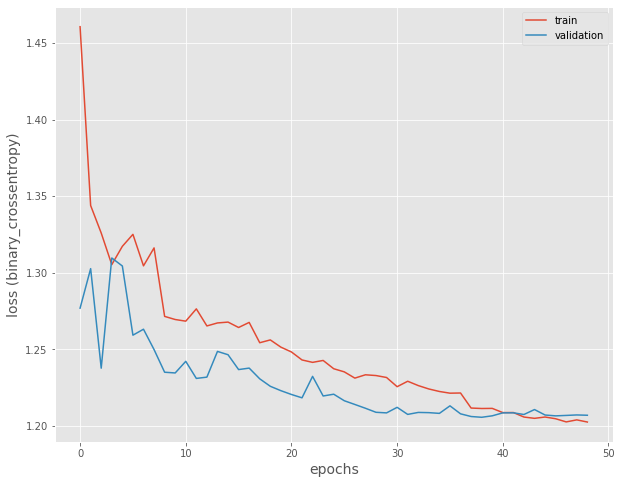

In [291]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.xlabel('epochs', fontsize=14)
plt.ylabel('loss (binary_crossentropy)', fontsize=14)
plt.legend()

In [292]:
from sklearn import metrics as met

pred=model.predict(x_test)
pred_valid=model.predict(x_valid)
pred_train=model.predict(x_train)

197/197 [==============================] - 11s 53ms/step


In [143]:
pred.shape

(785, 14)

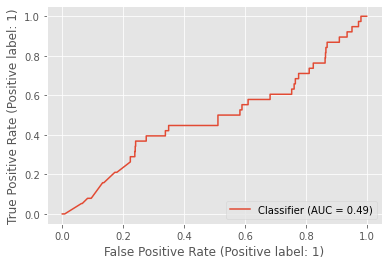

In [295]:
met.RocCurveDisplay.from_predictions(y_test[:,4],pred[:,4])

In [273]:
from sklearn.metrics import confusion_matrix
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions.argmax(1))
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


In [275]:
baseline_results = model.evaluate(x_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

y_cm = metadata_train['target'].values
my_dict={42: 0,
        52: 0,
        62: 0,
        67: 0,
        90: 0,
        6: 1,
       64: 1,
       65: 1,
       15: 2,
       95: 2,
       16: 3,
        53: 3,
        92: 3,
        88:4
        }
y_cm=[my_dict[i] for i in y]

plot_cm(y_test, pred)


loss :  2.5695900917053223
tp :  0.0
fp :  0.0
tn :  3140.0
fn :  785.0
accuracy :  0.800000011920929
precision :  0.0
recall :  0.0
auc :  0.2611464858055115
prc :  0.13001985847949982



ValueError: ignored

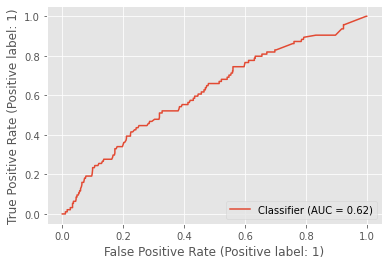

In [169]:
met.RocCurveDisplay.from_predictions(y_valid[:,2],pred_valid[:,2])

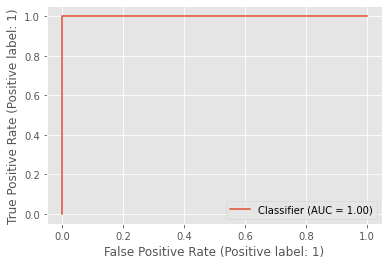

In [166]:
met.RocCurveDisplay.from_predictions(y_train[:,5],pred_train[:,5])

In [308]:
test=tf.convert_to_tensor(tables)

ValueError: ignored

In [303]:
test

<tf.Tensor: shape=(7063, 14), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>